['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'cat', 'dog', '']
{'car': '750', 'truck': '750', 'bus': '750', 'motorcycle': '100'}
16
Loading images...
Images loaded
LOADING LATEST
C:\Users\keela\Documents\Models\Old_Models\2kim.0001LR\weights_epoch_434
Detector loaded
1/1 [==============================] - 2s 2s/step
[[-133.36728    30.532684  288.11215   238.66336 ]
 [-133.15564   622.35474   287.5655    238.88477 ]
 [-132.517     142.57056   286.52603   238.86249 ]
 ...
 [ 492.9903    571.12146   602.0551    579.8362  ]
 [ 559.12354   574.17035   599.7423    577.701   ]
 [ 595.65094   591.5293    579.0313    556.83887 ]]
Margin: 1.000030279159546
Original Box coordinates: ymin=30, xmin=0, ymax=269, xmax=154
Margin: 1.0000213384628296
Original Box coordinates: ymin=622, xmin=0, ymax=640, xmax=154
Margin: 1.0000133514404297
Original Box coordinates: ymin=142, xmin=0, ymax=381, xmax

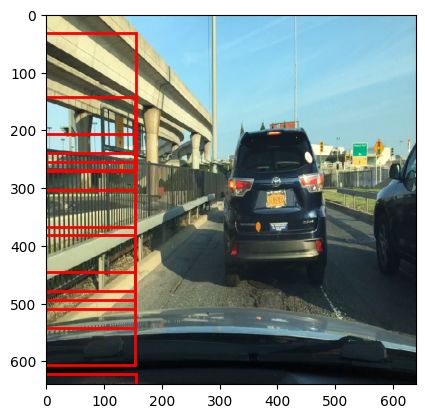

In [36]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET
import tensorflow_probability as tfp
from utils.coco_dataset_manager import *
from utils.yolo_utils import *
from utils.custom_retinanet import prepare_image
from utils.nonmaxsuppression import *
from utils.negloglikely import nll
from utils.yolov8prob import ProbYolov8Detector
from PIL import Image
import matplotlib.pyplot as plt
import pickle

#import torch

tf.keras.backend.clear_session()
tf.compat.v1.enable_eager_execution()
#torch.cuda.empty_cache()

# Hardcode paths and parameters

def visualize_boxes(frame, boxes):
    plt.imshow(frame)

    # Get the dimensions of the resized frame used for object detection
    for box in boxes:
        x, y, w, h = box
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)

    plt.show()





def use_model(checkpoint_path = r"C:\Users\keela\Documents\Models\mse_help_boxes",\
              image_folder = r"C:\Users\keela\Documents\Video Outputs\0000f77c-6257be58\frames",\
              cls_path = r"C:\Users\keela\Documents\Prebayesian\class_list_traffic.txt",\
              download_path = r"C:\Users\keela\Documents\Prebayesian\download_list_traffic.txt",\
              loss_function = "mse",  # mse, cce, or pos,\
              nms_layer = 'Softmax',  # Softmax or SoftmaxSum,\
              min_confidence = 0.018,\
              label_smoothing = 0.1,\
              LEARNING_RATE = 0.0001,\
              GLOBAL_CLIPNORM = 5):
    
    # Load the class lists from text; if not specified, it gets all 80 classes
    cls_list = None
    if cls_path:
        with open(cls_path) as f:
            cls_list = [cls.strip() for cls in f.readlines()]

    print(cls_list)

    download_list = None
    if download_path and download_path != "False":
        with open(download_path) as f:
            download_lines = f.readlines()
            download_list = {line.split(",")[0]: line.split(",")[1].strip() for line in download_lines}

    print(download_list)

    # The detector will only be the length of the class list
    num_classes = 80 if cls_list is None else len(cls_list)

    print(num_classes)

    # Augmenter and resizing
    augmenter = keras.Sequential(
        layers=[
            keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
            keras_cv.layers.RandomShear(x_factor=0.2, y_factor=0.2, bounding_box_format="xywh"),
            keras_cv.layers.JitteredResize(target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"),
        ]
    )
    resizing = keras_cv.layers.JitteredResize(
        target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
    )

    # Function to convert dictionary inputs to tuple
    def dict_to_tuple(inputs):
        return inputs["images"], inputs["bounding_boxes"]
    
    # NMS function
    nms_fn = DistributionNMS if nms_layer == 'Softmax' else PreSoftSumNMS
    detector = ProbYolov8Detector(num_classes, min_confidence=min_confidence, nms_fn=nms_fn, backbone_name = "yolo_v8_s_backbone_coco")
    label_smooth = max(min(label_smoothing, 1), 0)
    classification_loss = keras.losses.MeanSquaredError(
        reduction="sum",
    )
    if loss_function == 'cce':
        classification_loss = keras.losses.CategoricalCrossentropy(
            reduction="sum", from_logits=True, label_smoothing=label_smooth
        )
    if loss_function == 'pos':
        classification_loss = keras.losses.Poisson(
            reduction="sum"
        )
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=LEARNING_RATE, global_clipnorm=GLOBAL_CLIPNORM,
    )
    detector.model.compile(
        optimizer=optimizer, classification_loss=classification_loss, box_loss="ciou", jit_compile=False,
        box_loss_weight=7.5,
        classification_loss_weight=0.5,
    )
    
    print("Loading images...")
    # Get a list of all image files in the folder
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
    file_count = len(image_files)
    print("Images loaded")
    
    # Load detector Weights
    detector.load_weights(checkpoint_path)
    print("Detector loaded")
    
    # Define a function to load and preprocess a single image
    def load_and_preprocess_image(img_path):
        img = load_img(img_path, target_size=(640, 640))
        img_array = img_to_array(img)
        img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32) / 255.0
        return img_tensor
    
    detection_results = {}
    prev_max = 0
    how_many_frames = 1
    
    for frame_number, frame_path in enumerate(image_files[:how_many_frames]):
        checkpoint = round(frame_number / 5 * 100, 0)  # Adjust progress calculation for 5 frames
        if checkpoint > prev_max:
            print(f"{checkpoint}%")
        prev_max = checkpoint
    
        frame = load_and_preprocess_image(os.path.join(image_folder, frame_path))
    
        # Perform object detection
        detections = detector(frame)
        boxes = np.asarray(detections["boxes"])
        cls_prob = np.asarray(detections["cls_prob"])

        print(boxes)
    
        saved_boxes = []
        saved_probs = []
    
        counter = 0
        # Get bounding box and class names
        for box, prob_list in zip(boxes, cls_prob):
            cur_min = np.min(prob_list)
    
            probability = max(prob_list)
    
            if probability > cur_min * 1.00001:
                print(f"Margin: {probability / cur_min}")
                counter += 1
                chosen_class = np.argmax(prob_list)
                name = cls_list[chosen_class]
    
                # Extract coordinates
                x, y, w, h = box

                xmin = x
                ymin = y
                xmax = x+w
                ymax = y+h

                # Scale the coordinates based on the resized frame
                xmin = max(0, int(xmin))
                ymin = max(0, int(ymin))
                xmax = min(640, int(xmax))
                ymax = min(640, int(ymax))
                
                print(f"Original Box coordinates: ymin={ymin}, xmin={xmin}, ymax={ymax}, xmax={xmax}")
    
                saved_boxes.append(box)
                saved_probs.append(prob_list)
    
        visualize_boxes(frame, saved_boxes)
        plt.show()
    
if __name__ == '__main__':
    use_model(checkpoint_path = r"C:\Users\keela\Documents\Models\Old_Models\binary_crossentropy",
              cls_path = r"C:\Users\keela\Documents\Prebayesian\class_list_traffic_16.txt")
    

In [ ]:
!git commit --all -m "Saving model demo"